<a href="https://colab.research.google.com/github/DorAzaria/Voice-Emotion-Recognition/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***A Fine-tuned Wav2Vec2.0 For Speech Emotion Recognition***

By Dolev Abuhazira and Dor Azaria.

In [1]:
from google.colab import drive
drive.mount('/content/data/')

Mounted at /content/data/


#### ***Imports***

In [2]:
%%capture

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchaudio
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import mat
np.set_printoptions(suppress=True)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = {0: 'positive', 1:'neutral', 2:'negative'}

### ***Preprocessed Data***
---

Data class contains the dataset (for each audio file: audio_path, features, label). ``dataset5.pth`` contains extracted features used by Wav2Vec2 pretrained model,  the audio files are from RAVDESS, TESS and URDU datasets. - for more details about the preprocess [click here](https://github.com/DorAzaria/Voice-Emotion-Recognition/blob/main/preprocess.ipynb).


***Train-Valid-Test Split***

* You need to separate your input data into training, validation, and testing subsets to prevent your model from overfitting and to evaluate your model effectively.

* We split ``self.data`` into random 80% train, 10% test and 10% valid subsets using the ``train_test_split``.

***DataLoader***

Each subset (train, test, valid) will be a ``TensorLoader`` type that represents a Python iterable over a dataset.

By using ``TensorLoader`` we can easily:
1. Activate an automatic batching method (Using ``batch_size=32``).
2. Drop the last incomplete batch, if the dataset size is not divisible by the batch size (Using ``drop_last=True``).
3. To have the data reshuffled at every epoch (Using ``shuffle=True``). For Example, you are writing a classifier for 10 different category and see category 1 as first 1000 examples and so on for rest of the category. In such a cases, networks is first overfitting to category 1 and then to other category. Network in such cases, is not able to generalize it’s learning for all the categories.

In [3]:
class Data:

    def __init__(self):
        file_handler = open('/content/data/MyDrive/dl/dataset5.pth', 'rb')
        self.data = pickle.load(file_handler)

        x_dataset = [embedding[1] for embedding in self.data]
        y_dataset = [label[2] for label in self.data]

        #[80% train, 10% valid, 10% test]
        train_x, rem_x, train_y, rem_y = train_test_split(np.array(x_dataset), np.array(y_dataset), train_size=0.80) 
        valid_x, test_x, valid_y, test_y = train_test_split(rem_x, rem_y, test_size=0.5)

        # Convert numpy to torch.Tensor type
        self.train_x = torch.from_numpy(train_x)
        self.train_y = torch.from_numpy(train_y)

        self.valid_x = torch.from_numpy(valid_x)
        self.valid_y = torch.from_numpy(valid_y)

        self.test_x = torch.from_numpy(test_x)
        self.test_y = torch.from_numpy(test_y)

        # Create a DataLoader for each subset (train, valid, test)
        torch_train = TensorDataset(self.train_x, self.train_y)
        torch_valid = TensorDataset(self.valid_x, self.valid_y)
        torch_test = TensorDataset(self.test_x, self.test_y)

        self.train_loader = DataLoader(torch_train, batch_size=32, drop_last=True, shuffle=True)
        self.valid_loader = DataLoader(torch_valid, batch_size=32, drop_last=True, shuffle=True)
        self.test_loader = DataLoader(torch_test, batch_size=32, drop_last=True, shuffle=False)

**Plot**

Prints the train loss vs. valid loss when an earlystopping occurs.

In [4]:
def plotEarlyStopping(train_loss, valid_loss):
  epochs_x_axis = np.linspace(1, len(train_loss), len(train_loss)).astype(int)
  plt.plot(epochs_x_axis, train_loss)
  plt.plot(epochs_x_axis, valid_loss)
  plt.title('Train VS Valid Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'], loc='upper left')
  plt.savefig("model_plot.png")

### ***ConvNet Class Model***
---

The ``ConvNet`` model is a convolutional neural network. The model subclass ``torch.nn.Module`` which is a base class for all neural network modules.
The model architecture using ``BatchNorm2d()``,  ``MaxPool2d()`` , ``ReLU()``and more methods from ``nn.Module``.

* ***Epoch*** - The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters. An epoch is comprised of one or more batches.

* ***Batch*** - A training dataset can be divided into one or more batches. It requires less memory. Typically networks train faster with mini-batches, that's because we update the weights after each propagation. But on the other hand, the smaller the batch the less accurate the estimate of the gradient will be.

* ***Learning Rate*** - The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated.

* ***ReLU*** - Why to use this activition function?
  1.  It helps to prevent the exponential growth in the computation required to operate the neural network. If the CNN scales in size, the computational cost of adding extra ReLUs increases linearly.
  2.  Unlike the $tanh$ and $sigmoid$ activation functions that learn to approximate a zero output, it's capable of outputting a true zero value. Having a true zero values can speed up learning and simplify the model. 
  3. It's mostly looks and acts like a linear activation function. Because of this linearity, gradients flow well on the active paths of neurons (there is no gradient vanishing effect due to activation non-linearities of $sigmoid$ or $tanh$ units). 

The input size of the network is (1, 149, 32).

In [ ]:
DROP_OUT = 0.8
NUM_OF_CLASSES = 3

class ConvNet(nn.Module):

    def __init__(self):
        super().__init__()

        # Hyper parameters
        self.epochs = 20
        self.batch_size = 32
        self.learning_rate = 0.0001

        # Model Architecture
        self.first_conv = nn.Conv2d(1, 96, kernel_size=(5, 5), padding=1) # (96, 147, 30)
        self.first_bn = nn.BatchNorm2d(96)
        self.first_polling = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2)) # (96, 73, 14)

        self.second_conv = nn.Conv2d(96, 256, kernel_size=(5, 5), padding=1) # (256, 71, 12)
        self.second_bn = nn.BatchNorm2d(256)
        self.second_polling = nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1)) # (256, 69, 10)

        self.third_conv = nn.Conv2d(256, 384, kernel_size=(3, 3), padding=1) # (384, 69, 10 )
        self.third_bn = nn.BatchNorm2d(384)

        self.forth_conv = nn.Conv2d(384, 256, kernel_size=(3, 3), padding=1) # (256, 69, 10)
        self.forth_bn = nn.BatchNorm2d(256)

        self.fifth_conv = nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1) # (256, 69, 10)
        self.fifth_bn = nn.BatchNorm2d(256)
        self.fifth_polling = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1)) # (256, 68, 9)

        self.sixth_conv = nn.Conv2d(256, 64, kernel_size=(2, 2), padding=1) # (64, 69, 10)

        self.seventh_conv = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1) # (64, 69, 10)
        self.seventh_polling = nn.MaxPool2d(kernel_size=(2,2), stride=(2, 2)) # (64, 34, 5)

        self.eighth_conv = nn.Conv2d(64, 32, kernel_size=(3,3), padding=1) # (32, 34, 5)
        self.first_drop = nn.Dropout(p=DROP_OUT)

        self.avg_polling = nn.AdaptiveAvgPool2d((1, 1))
        self.first_dense = nn.Linear(32, 1024)
        self.second_drop = nn.Dropout(p=DROP_OUT)

        self.second_dense = nn.Linear(1024, NUM_OF_CLASSES)

    def forward(self, X):
        x = nn.ReLU()(self.first_conv(X))
        x = self.first_bn(x)
        x = self.first_polling(x)

        x = nn.ReLU()(self.second_conv(x))
        x = self.second_bn(x)
        x = self.second_polling(x)

        x = nn.ReLU()(self.third_conv(x))
        x = self.third_bn(x)

        x = nn.ReLU()(self.forth_conv(x))
        x = self.forth_bn(x)

        x = nn.ReLU()(self.fifth_conv(x))
        x = self.fifth_bn(x)
        x = self.fifth_polling(x)

        x = nn.ReLU()(self.sixth_conv(x))

        x = nn.ReLU()(self.seventh_conv(x))
        x = self.seventh_polling(x)

        x = nn.ReLU()(self.eighth_conv(x))

        x = self.first_drop(x)
        x = self.avg_polling(x)

        x = x.view(-1, x.shape[1])  # output channel for flatten before entering the dense layer

        x = nn.ReLU()(self.first_dense(x))
        x = self.second_drop(x)

        x = self.second_dense(x)
        y = nn.LogSoftmax(dim=1)(x)  # torch.Size([32, 3])

        return y

    def get_epochs(self):
        return self.epochs

    def get_learning_rate(self):
        return self.learning_rate

    def get_batch_size(self):
        return self.batch_size

### ***Validation***
---

* ``validation()`` gets the model, dataset and the loss function and returns the loss.


* The valid dataset is a set of data used to provide an unbiased evaluation of a model fitted on the training dataset while tuning model hyperparameters. It's also play a role in the EarlyStopping technique.

In [ ]:
def validation(convnet_model, dataset, loss_function):
    model.eval()
    loss_total = 0

    with torch.no_grad():
        for embedding, labels in dataset.valid_loader:
            embedding = embedding.type(torch.FloatTensor)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            embedding = embedding.to(device)

            outputs = convnet_model(embedding)
            loss = loss_function(outputs, labels)
            loss_total += loss.item()

    return loss_total / len(dataset.valid_loader)

### ***Train***
---


In [ ]:
def train_model(convnet_model, dataset):
    loss_vals_train = []
    loss_valid = []

    optimizer = torch.optim.Adam(convnet_model.parameters(), lr=convnet_model.learning_rate, weight_decay=1e-4)
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.99, 3.0, 1.0])).to(device) # [1184, 688, 2363] --> 4235 examples
    
    n_total_steps = len(dataset.train_loader)

    for epoch in range(convnet_model.get_epochs()):

        convnet_model.train()
        epoch_acc = []
        epoch_loss = []

        for i, (embedding, labels) in enumerate(dataset.train_loader):

            embedding = embedding.type(torch.FloatTensor)
            labels = labels.type(torch.LongTensor)
        
            labels = labels.to(device)
            embedding = embedding.to(device)

            # Forward pass
            outputs = convnet_model.forward(embedding)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            if i == 90:
                print(f'Epoch [{epoch + 1}/{convnet_model.epochs}], Loss: {loss.item():.4f}')
                
        loss_vals_train.append(sum(epoch_loss)/len(epoch_loss))


        #### EARLY STOPPING ~~~~~~~~~~~~~~~~~~~
        the_last_loss = 100
        the_current_loss = validation(convnet_model, dataset, criterion)
        loss_valid.append(the_current_loss)

        if the_current_loss > loss_vals_train[-1]:
            print('Early stopping!')
            torch.save(cnn, "/content/model444.pth")
            plotEarlyStopping(loss_vals_train,loss_valid)
            print(f'saved model444.pth')
            break

        the_last_loss = the_current_loss
        ##### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


***Start Train***



Epoch [1/20], Loss: 1.1094
Epoch [2/20], Loss: 0.8018
Epoch [3/20], Loss: 0.9119
Epoch [4/20], Loss: 0.7460
Epoch [5/20], Loss: 0.6920
Epoch [6/20], Loss: 0.4575
Epoch [7/20], Loss: 0.4185
Early stopping!
saved model444.pth


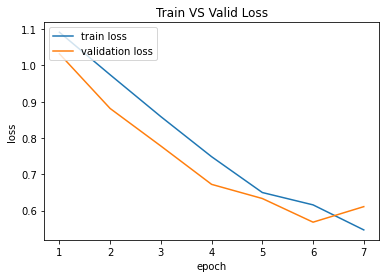

In [ ]:
dataset = Data()
cnn = ConvNet()
cnn.to(device)
train_model(cnn, dataset)

### ***Test***
---

* You can’t evaluate the predictive performance of a model with the same data you used for training. It would be best if you evaluated the model with new data that hasn’t been seen by the model before. Randomly splitting the data is the most commonly used method for that unbiased evaluation.

* ``torch.max()`` returns a namedtuple (values, indices) where values is the maximum value of each row of the input tensor in the given dimension dim. And indices is the index location of each maximum value found (argmax).

In [ ]:
def test(convnet_model, dataset):

    example_class = [0] * len(dataset.test_y) 
    text_results = []
    acc_classes = [0,0,0]
    
    with torch.no_grad():
        total_correct = 0
        example_index = 0
        label_correct = [0, 0 , 0]
        label_samples = [0, 0 , 0]
        
        for embedding, labels in dataset.test_loader:
            
            embedding = embedding.type(torch.FloatTensor)
            labels = labels.type(torch.LongTensor)
            embedding = embedding.to(device)
            labels = labels.to(device)
            
            outputs = convnet_model(embedding)
            _, predicted = torch.max(input= outputs, dim=1)

            total_correct += (predicted == labels).sum().item()

            for i in range(convnet_model.batch_size):
                label = labels[i]
                pred = predicted[i]

                if label == pred:
                    label_correct[label] += 1

                label_samples[label] += 1
                example_class[example_index] = pred.cpu()
                example_index += 1

        acc = 100.0 * total_correct / len(dataset.test_y)
        text_results.append(f'Accuracy of the network: {acc} %')

        for i in range(3):
            acc = 100.0 * label_correct[i] / label_samples[i]
            text_results.append(f'Accuracy of {classes[i]}: {acc} %')
            acc_classes[i] = acc
        
        return example_class, text_results, acc_classes

In case you want to test a trained model:

In [ ]:
model_import = torch.load("/content/data/MyDrive/dl/model208.pth")

***Start Test***


Accuracy of the network: 70.4326923076923 %

Accuracy of positive: 72.88135593220339 %

Accuracy of neutral: 81.48148148148148 %

Accuracy of negative: 66.80327868852459 %



In [ ]:
dataset = Data()
n_class, text_results, acc_classes  = test(model_import, dataset)

for text in text_results:
  print(text)

Accuracy of the network: 69.33962264150944 %
Accuracy of positive: 69.64285714285714 %
Accuracy of neutral: 79.16666666666667 %
Accuracy of negative: 68.53448275862068 %


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
arr = confusion_matrix(dataset.test_y.detach().cpu().numpy(), n_class)
class_names = ['Positive', 'Neutral ', 'Negative']

def confusion_matrix(n_class):
    # Display the confusion matrix as a heatmap
    df_cm = pd.DataFrame(arr, class_names, class_names)
    plt.figure(figsize = (9,6))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")
    plt.show()

def summary(acc_classes):
  f1_score = [0,0,0]
  accuracy = [0,0,0]
  recall = [0,0,0]
  precision = [0,0,0]
  print("Class         Precision      Recall     F1-Score      Accuracy")
  print("-----------------------------------------------------------------")
  for i in range (3):
    numerator = arr[i][i]
    recall_denominator = 0
    precision_denominator = 0
    for j in range(3):
      recall_denominator += arr[i][j]
      precision_denominator += arr[j][i]
    
    recall[i] = round(numerator/recall_denominator,2)
    precision[i] = round(numerator/precision_denominator,2)
    f1_score[i] = round((2*recall[i]*precision[i])/(recall[i]+precision[i]),2)
    print(f'{class_names[i]}    |    {precision[i]}    |    {recall[i]}    |    {f1_score[i]}    |    {round(acc_classes[i],2)}')
  print('')

Class         Precision      Recall     F1-Score      Accuracy
-----------------------------------------------------------------
Positive    |    0.63    |    0.7    |    0.66    |    69.64
Neutral     |    0.49    |    0.77    |    0.6    |    79.17
Negative    |    0.88    |    0.67    |    0.76    |    68.53



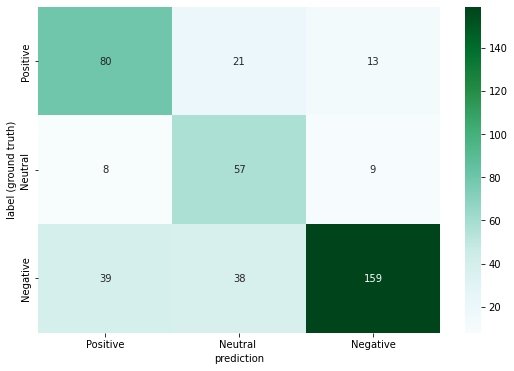

In [ ]:
summary(acc_classes)
confusion_matrix(n_class)

### ***Inference And Normalization***

---



In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)


def inference(file_name):
    SAMPLE_RATE = 16000
    waveform, sample_rate = torchaudio.load(filepath=file_name,  num_frames=SAMPLE_RATE * 3)
    # waveform = waveform.view(1, 96000)
    waveform = waveform.to(device)
    
    if (len(waveform[0]) < 48000):
        print(f'less than 3 seconds: {file_name}')

    if sample_rate != bundle.sample_rate:
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

    with torch.inference_mode():
        embedding, _ = model(waveform)

    return embedding.unsqueeze(0)


def Norm(X):
    embedding = X.detach().cpu().numpy()
    for i in range(len(embedding)):
        mlist = embedding[0][i]
        embedding[0][i] = 2 * (mlist - np.max(mlist)) / (np.max(mlist) - np.min(mlist)) + 1

    return torch.from_numpy(embedding).to(device)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

In [ ]:
def print_results(y):
  predict = [np.exp(c) for c in y]
  max = np.argmax(predict)
  print(f'Predicted: {classes[max].capitalize()}')
  print(f'Positive: {round(predict[0][0]*100, 4)}%')
  print(f'Neutral: {round(predict[0][1]*100, 4)}%')
  print(f'Negative: {round(predict[0][2]*100, 4)}%')

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

In [ ]:
# NEGATIVE TRUTH
inf_X = inference('/content/data/MyDrive/dl/ravdess/Actor_01/03-01-05-01-01-02-01.wav')
X = Norm(inf_X)
y = model_import.forward(X)
y = y.cpu().detach().numpy()
print_results(y)

Predicted: Negative
Positive: 23.5272%
Neutral: 8.7663%
Negative: 67.7065%
